In [1]:
from prophet import Prophet
from neuralprophet import NeuralProphet, set_log_level
from matplotlib import pyplot as plt
import pandas as pd
import logging
import warnings

set_log_level("ERROR")
logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')

In [3]:
p = Prophet()
p.fit(df)
future = p.make_future_dataframe(periods=366)

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7976.8     0.0116281       1836.61           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7995.14    0.00107664       277.275      0.2356      0.2356      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7998.06    0.00084367       63.3809           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       7999.77    8.5129e-05       263.562   2.325e-07       0.001      492  LS failed, Hessian reset 
     399       8000.82   5.46984e-05       109.538      0.8049      0.8049      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8002.78    0.00125019    

In [4]:
np = NeuralProphet()
np.fit(df)
future = np.make_future_dataframe(df, periods=366)

  0%|          | 0/136 [00:00<?, ?it/s]

{'self': <neuralprophet.forecaster.NeuralProphet object at 0x13d8ea820>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': None, 'quantiles': None, 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


  0%|          | 0/136 [00:00<?, ?it/s]

### Modeling Holidays and Special Events
If you have holidays or other recurring events that you'd like to model, you must create a dataframe for them. It has two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won't repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns `lower_window` and `upper_window` which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you'd include `lower_window=-1,upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you'd include `lower_window=0,upper_window=1`. You can also include a column `prior_scale` to set the prior scale separately for each holiday, as described below.

Here we create a dataframe that includes the dates of all of Peyton Manning's playoff appearances:

In [5]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

Above we have included the superbowl days as both playoff games and superbowl games. This means that the superbowl effect will be an additional additive bonus on top of the playoff effect.

Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument. Here we do it with the Peyton Manning data from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html):

In [6]:
p = Prophet(holidays=holidays)
forecast_p = p.fit(df).predict(future)

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8123.95    0.00125246       313.226       0.313       0.313      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8141.42     0.0057827       649.682           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8146.56     0.0347987       803.918           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8151.21    0.00124078       222.862      0.7369      0.7369      480   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       8151.74   2.40987e-05       80.5322   1.741e-07       0.001      584  LS failed, Hessian reset 
     499       8152.01    0.00130881    

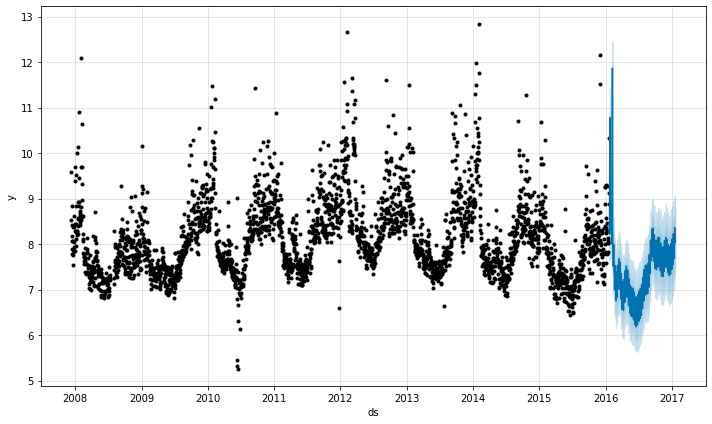

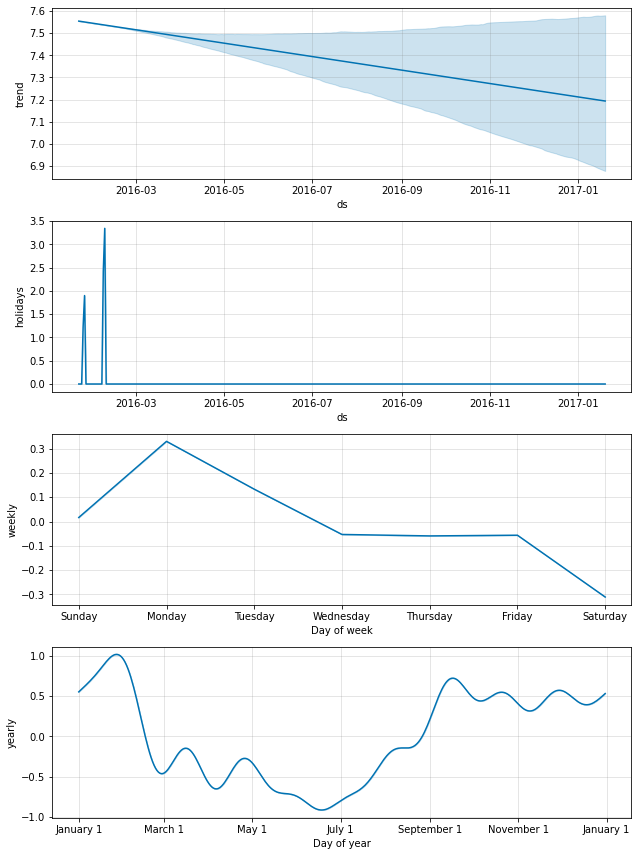

In [7]:
fig = p.plot(forecast_p)
fig = p.plot_components(forecast_p)

In [8]:
np = NeuralProphet(loss_func="MSE", n_changepoints=0, quantiles=[0.1, 0.9])

# set the model to expect these events
np = np.add_events(["playoff", "superbowl"], lower_window=0, upper_window=1)

# create the data df with events
holidays_copy = holidays.copy()
holidays_copy.rename(columns={"holiday": "event"}, inplace=True) # rename holiday to event
history_df = np.create_df_with_events(df, holidays_copy)

# Fit the model
metrics = np.fit(history_df, freq="D")

# forecast with events known ahead
future = np.make_future_dataframe(df=history_df, events_df=holidays_copy, periods=365, n_historic_predictions=len(df))
forecast_np = np.predict(df=future)

  0%|          | 0/136 [00:00<?, ?it/s]

{'self': <neuralprophet.forecaster.NeuralProphet object at 0x13dd493a0>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 0, 'changepoints_range': 0.9, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': None, 'quantiles': [0.1, 0.9], 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


  0%|          | 0/136 [00:00<?, ?it/s]

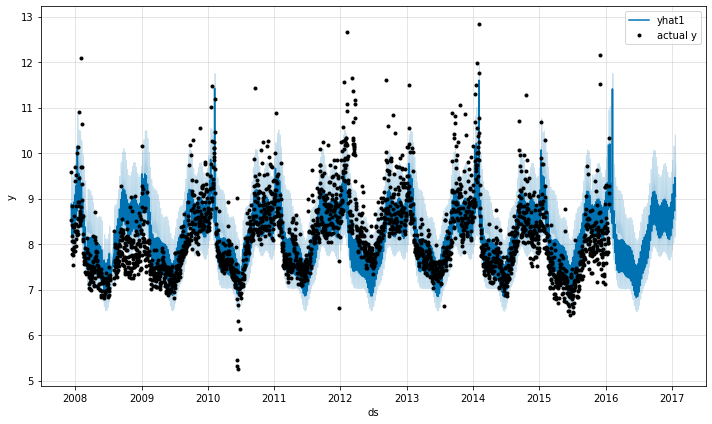

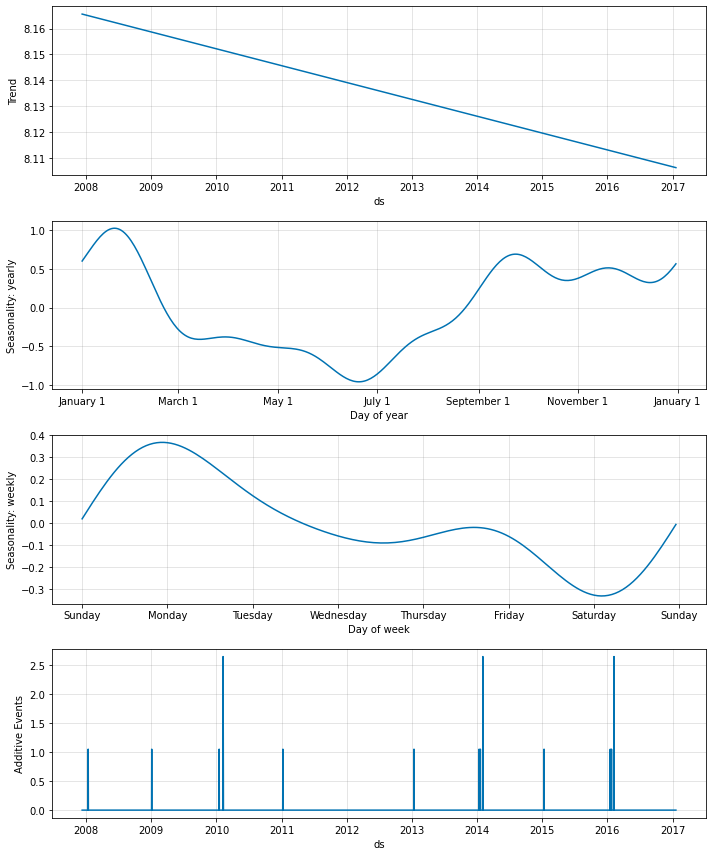

In [9]:
fig = np.plot(forecast_np)
fig = np.plot_components(forecast_np)

### Built-in Country Holidays

You can use a built-in collection of country-specific holidays using the `add_country_holidays` method (Python) or function (R). The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the `holidays` argument described above:

In [12]:
p = Prophet(holidays=holidays)
p.add_country_holidays(country_name='US')
p.fit(df)

Initial log joint probability = -19.4685


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8149.88    0.00314416       326.249           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8174.01    0.00369185       542.687           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8178.69     0.0105957       901.662      0.2104      0.2104      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8183.55   0.000567334       200.585       0.247       0.247      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     484       8184.57   9.73171e-05       305.251   3.237e-07       0.001      621  LS failed, Hessian reset 
     499       8184.77   0.000186979       242.592      0.3288      0.6701      6

You can see which holidays were included by looking at the `train_holiday_names` (Python) or `train.holiday.names` (R) attribute of the model:

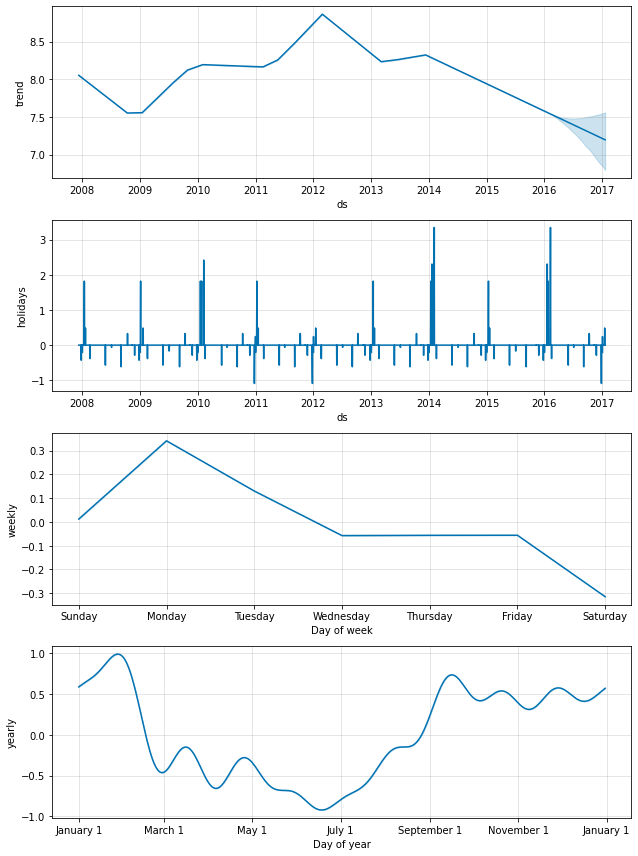

In [22]:
forecast = p.predict(future)
fig = p.plot_components(forecast)

In [14]:
np = NeuralProphet()
np.add_country_holidays(country_name='US')
np.fit(df)

  0%|          | 0/136 [00:00<?, ?it/s]

{'self': <neuralprophet.forecaster.NeuralProphet object at 0x13eeaea30>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': None, 'quantiles': None, 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


  0%|          | 0/136 [00:00<?, ?it/s]

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
0,1.264340,7.611778,9.835162,0.886155,0.0
1,0.670955,4.820323,6.173995,0.451812,0.0
2,0.310544,2.970394,3.628489,0.191454,0.0
3,0.123094,1.701730,2.194780,0.072034,0.0
4,0.038005,0.866792,1.199994,0.022057,0.0
...,...,...,...,...,...
137,0.006278,0.353623,0.491659,0.004806,0.0
138,0.006196,0.351026,0.484466,0.004735,0.0
139,0.006143,0.347437,0.480035,0.004704,0.0
140,0.006105,0.348716,0.480258,0.004674,0.0


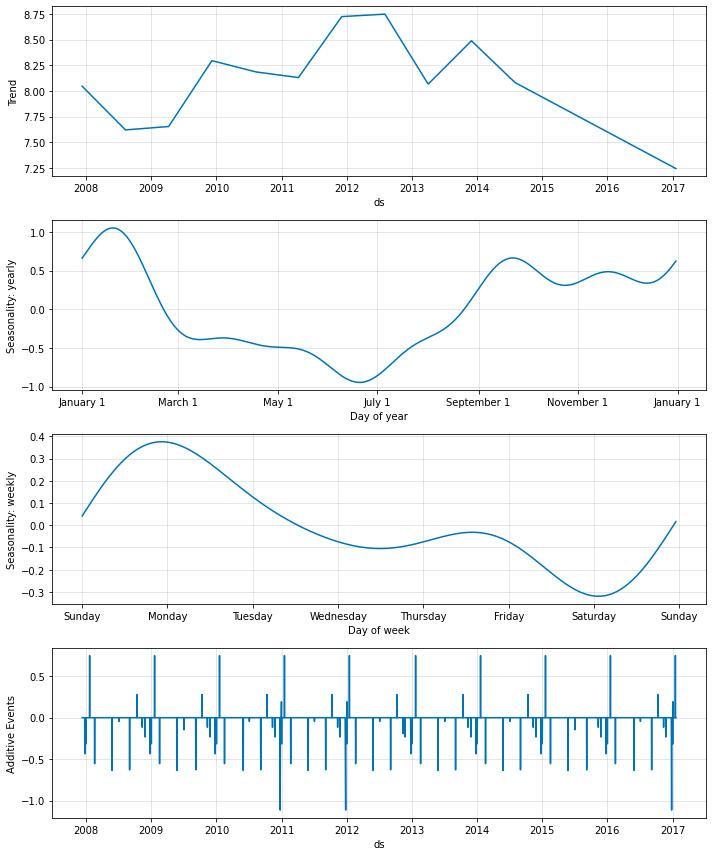

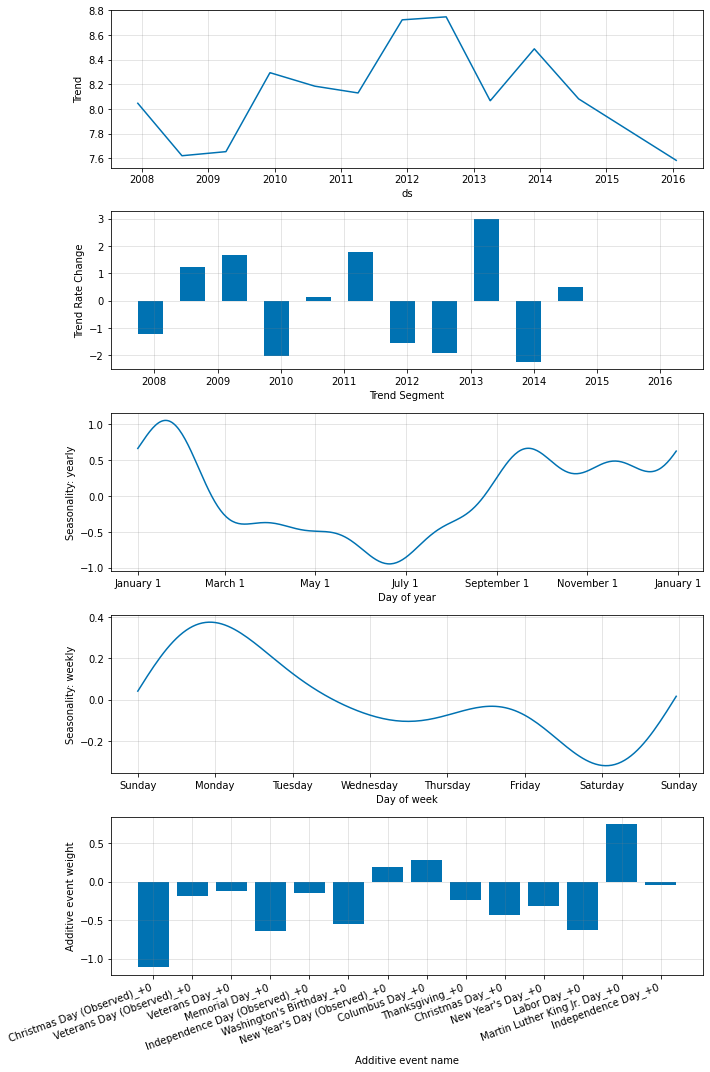

In [20]:
forecast = np.predict(future.drop(["playoff", "superbowl"], axis=1))
fig = np.plot_components(forecast)
fig = np.plot_parameters()

The holidays for each country are provided by the `holidays` package in Python. A list of available countries, and the country name to use, is available on their page: https://github.com/dr-prodigy/python-holidays. In addition to those countries, Prophet includes holidays for these countries: Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU), Korea (KR), Belarus (BY), and United Arab Emirates (AE).

In Python, most holidays are computed deterministically and so are available for any date range; a warning will be raised if dates fall outside the range supported by that country. In R, holiday dates are computed for 1995 through 2044 and stored in the package as `data-raw/generated_holidays.csv`. If a wider date range is needed, this script can be used to replace that file with a different date range: https://github.com/facebook/prophet/blob/main/python/scripts/generate_holidays_file.py.

As above, the country-level holidays will then show up in the components plot:

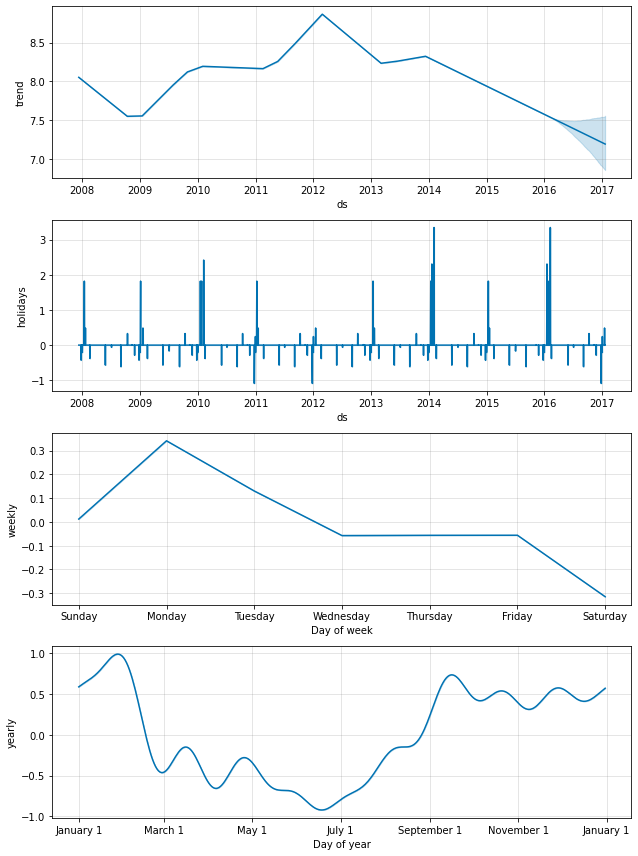

In [9]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

In [ ]:
## plotting components
fig = np.plot(forecast)
fig = m.plot_parameters()

### Fourier Order for Seasonalities

Seasonalities are estimated using a partial Fourier sum. See [the paper](https://peerj.com/preprints/3190/) for complete details, and [this figure on Wikipedia](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg) for an illustration of how a partial Fourier sum can approximate an arbitrary periodic signal. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. To illustrate this, consider the Peyton Manning data from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html). The default Fourier order for yearly seasonality is 10, which produces this fit:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7976.8     0.0116281       1836.61           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7995.14    0.00107664       277.275      0.2356      0.2356      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7998.06    0.00084367       63.3809           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       7999.77    8.5129e-05       263.562   2.325e-07       0.001      492  LS failed, Hessian reset 
     399       8000.82   5.46984e-05       109.538      0.8049      0.8049      548   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8002.78    0.00125019    

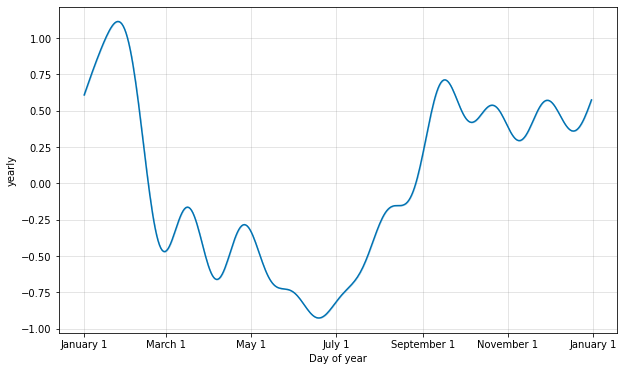

In [10]:
from prophet.plot import plot_yearly
m = Prophet().fit(df)
a = plot_yearly(m)

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here it is increased to 20:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8020.24     0.0128691       762.586           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       8038.02    0.00524315       416.027      0.7974      0.7974      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     274       8041.25   4.14348e-05       122.418   1.903e-07       0.001      403  LS failed, Hessian reset 
     299       8041.82   0.000296448       163.219      0.4523      0.4523      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8045.54    0.00150563       153.801       0.435           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     481       8046.63   2.33149e-05    

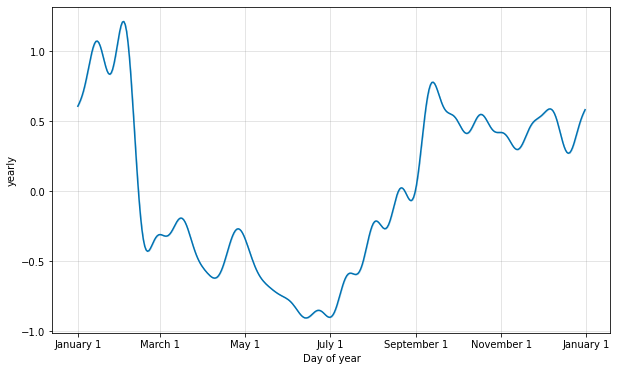

In [11]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(df)
a = plot_yearly(m)

Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle

### Specifying Custom Seasonalities

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method (Python) or function (R).

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. An optional input to `add_seasonality` is the prior scale for that seasonal component - this is discussed below.

As an example, here we fit the Peyton Manning data from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html), but replace the weekly seasonality with monthly seasonality. The monthly seasonality then will appear in the components plot:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7783.38    0.00117887        435.36      0.2015           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7798.59    0.00936528       326.316           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7801.35     0.0176403       566.482      0.6261           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       7802.11   0.000193439         152.7   1.943e-06       0.001      428  LS failed, Hessian reset 
     375        7802.9   4.04384e-05       106.519   2.365e-07       0.001      539  LS failed, Hessian reset 
     399       7803.05    0.00010911       64.5714       4.388      0.4388      572   
    Iter      log pro

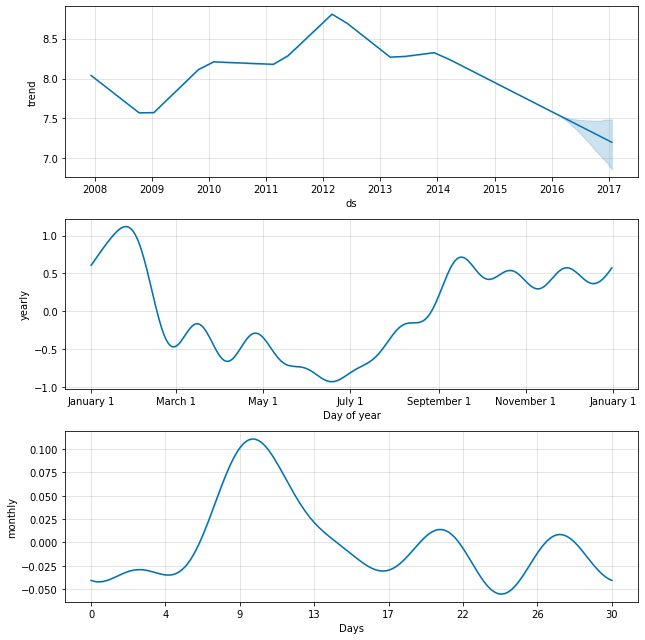

In [12]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

### Seasonalities that depend on other factors
In some instances the seasonality may depend on other factors, such as a weekly seasonal pattern that is different during the summer than it is during the rest of the year, or a daily seasonal pattern that is different on weekends vs. on weekdays. These types of seasonalities can be modeled using conditional seasonalities.

Consider the Peyton Manning example from the [Quickstart](https://facebook.github.io/prophet/docs/quick_start.html). The default weekly seasonality assumes that the pattern of weekly seasonality is the same throughout the year, but we'd expect the pattern of weekly seasonality to be different during the on-season (when there are games every Sunday) and the off-season. We can use conditional seasonalities to construct separate on-season and off-season weekly seasonalities.

First we add a boolean column to the dataframe that indicates whether each date is during the on-season or the off-season:

In [13]:
def is_nfl_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 8 or date.month < 2)

df['on_season'] = df['ds'].apply(is_nfl_season)
df['off_season'] = ~df['ds'].apply(is_nfl_season)

Then we disable the built-in weekly seasonality, and replace it with two weekly seasonalities that have these columns specified as a condition. This means that the seasonality will only be applied to dates where the `condition_name` column is `True`. We must also add the column to the `future` dataframe for which we are making predictions.

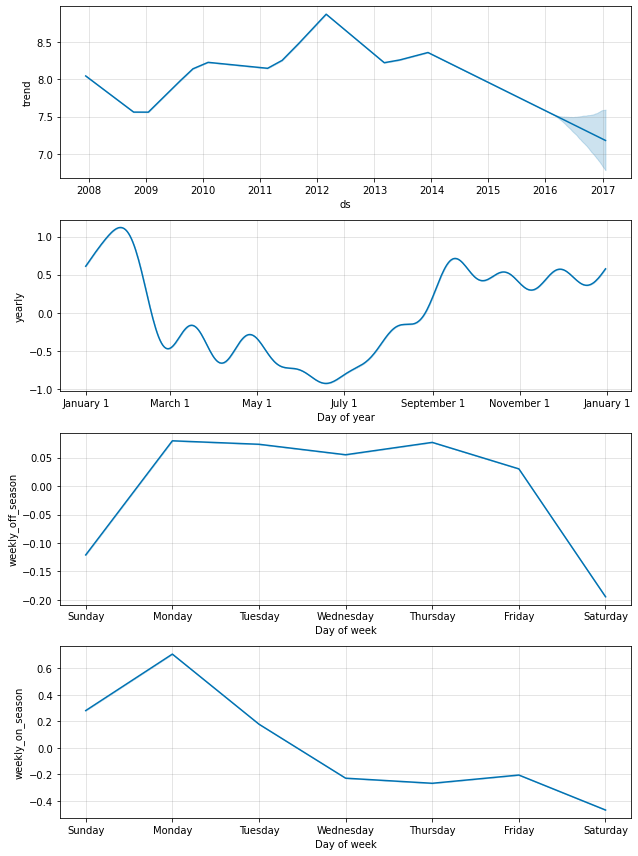

In [14]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='weekly_on_season', period=7, fourier_order=3, condition_name='on_season')
m.add_seasonality(name='weekly_off_season', period=7, fourier_order=3, condition_name='off_season')

future['on_season'] = future['ds'].apply(is_nfl_season)
future['off_season'] = ~future['ds'].apply(is_nfl_season)
forecast = m.fit(df).predict(future)
fig = m.plot_components(forecast)

Both of the seasonalities now show up in the components plots above. We can see that during the on-season when games are played every Sunday, there are large increases on Sunday and Monday that are completely absent during the off-season.

### Prior scale for holidays and seasonality
If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter `holidays_prior_scale`. By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects:

In [15]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.05).fit(df)
forecast = m.predict(future)
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
    ['ds', 'playoff', 'superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.206086,0.964914
2191,2014-02-03,1.852077,0.992634
2532,2015-01-11,1.206086,0.000000
2533,2015-01-12,1.852077,0.000000
2901,2016-01-17,1.206086,0.000000
2902,2016-01-18,1.852077,0.000000
2908,2016-01-24,1.206086,0.000000
2909,2016-01-25,1.852077,0.000000
2922,2016-02-07,1.206086,0.964914
2923,2016-02-08,1.852077,0.992634


The magnitude of the holiday effect has been reduced compared to before, especially for superbowls, which had the fewest observations. There is a parameter `seasonality_prior_scale` which similarly adjusts the extent to which the seasonality model will fit the data.

Prior scales can be set separately for individual holidays by including a column `prior_scale` in the holidays dataframe. Prior scales for individual seasonalities can be passed as an argument to `add_seasonality`. For instance, the prior scale for just weekly seasonality can be set using:

In [16]:
m = Prophet()
m.add_seasonality(
    name='weekly', period=7, fourier_order=3, prior_scale=0.1)


### Additional regressors
Additional regressors can be added to the linear part of the model using the `add_regressor` method or function. A column with the regressor value will need to be present in both the fitting and prediction dataframes. For example, we can add an additional effect on Sundays during the NFL season. On the components plot, this effect will show up in the 'extra_regressors' plot:

Initial log joint probability = -19.4685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       8011.57    0.00129547       173.109      0.4498      0.4498      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       8019.62   0.000145373       329.904   6.506e-07       0.001      217  LS failed, Hessian reset 
     199       8027.92    0.00302195       522.156      0.9459      0.9459      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       8034.38    0.00347896       304.326           1           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       8037.34   0.000384022       168.897      0.3189           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       8039.09    0.00347123    

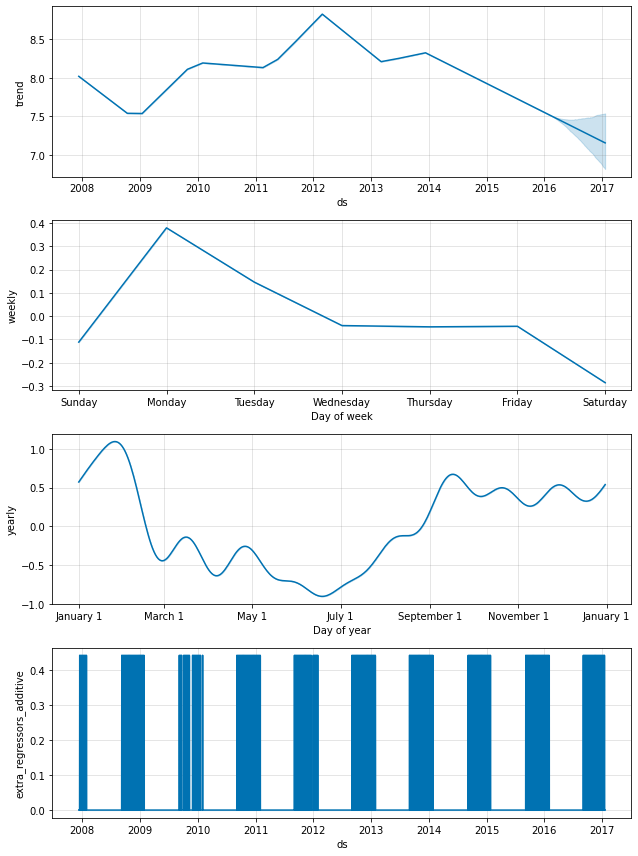

In [13]:
def nfl_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month > 8 or date.month < 2):
        return 1
    else:
        return 0
df['nfl_sunday'] = df['ds'].apply(nfl_sunday)

m = Prophet()
m.add_regressor('nfl_sunday')
m.fit(df)

future['nfl_sunday'] = future['ds'].apply(nfl_sunday)

forecast = m.predict(future)
fig = m.plot_components(forecast)

NFL Sundays could also have been handled using the "holidays" interface described above, by creating a list of past and future NFL Sundays. The `add_regressor` function provides a more general interface for defining extra linear regressors, and in particular does not require that the regressor be a binary indicator. Another time series could be used as a regressor, although its future values would have to be known.

[This notebook](https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb) shows an example of using weather factors as extra regressors in a forecast of bicycle usage, and provides an excellent illustration of how other time series can be included as extra regressors.

The `add_regressor` function has optional arguments for specifying the prior scale (holiday prior scale is used by default) and whether or not the regressor is standardized - see the docstring with `help(Prophet.add_regressor)` in Python and `?add_regressor` in R. Note that regressors must be added prior to model fitting. Prophet will also raise an error if the regressor is constant throughout the history, since there is nothing to fit from it.

The extra regressor must be known for both the history and for future dates. It thus must either be something that has known future values (such as `nfl_sunday`), or something that has separately been forecasted elsewhere. The weather regressors used in the notebook linked above is a good example of an extra regressor that has forecasts that can be used for future values. One can also use as a regressor another time series that has been forecasted with a time series model, such as Prophet. For instance, if `r(t)` is included as a regressor for `y(t)`, Prophet can be used to forecast `r(t)` and then that forecast can be plugged in as the future values when forecasting `y(t)`. A note of caution around this approach: This will probably not be useful unless `r(t)` is somehow easier to forecast then `y(t)`. This is because error in the forecast of `r(t)` will produce error in the forecast of `y(t)`. One setting where this can be useful is in hierarchical time series, where there is top-level forecast that has higher signal-to-noise and is thus easier to forecast. Its forecast can be included in the forecast for each lower-level series.

Extra regressors are put in the linear component of the model, so the underlying model is that the time series depends on the extra regressor as either an additive or multiplicative factor (see the next section for multiplicativity).

#### Coefficients of additional regressors

To extract the beta coefficients of the extra regressors, use the utility function `regressor_coefficients` (`from prophet.utilities import regressor_coefficients` in Python, `prophet::regressor_coefficients` in R) on the fitted model. The estimated beta coefficient for each regressor roughly represents the increase in prediction value for a unit increase in the regressor value (note that the coefficients returned are always on the scale of the original data). If `mcmc_samples` is specified, a credible interval for each coefficient is also returned, which can help identify whether each regressor is "statistically significant".